<a href="https://colab.research.google.com/github/svvuae/Python_Study/blob/main/SEE912_Q2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Download training and testing dataset from google drive**

In [3]:
import gdown
folder_id = '1sR02CtcPKx5ulQ8o0Y7598IbwvUF4kT0'
gdown.download_folder(id=folder_id, quiet=False, output="dataset")

Retrieving folder contents


Processing file 1FAjxELjsNOLt3PH045XtkWDbTV8IDIV_ test.zip
Processing file 19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y train.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1FAjxELjsNOLt3PH045XtkWDbTV8IDIV_
To: /content/dataset/test.zip
100%|██████████| 6.28M/6.28M [00:00<00:00, 15.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y
From (redirected): https://drive.google.com/uc?id=19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y&confirm=t&uuid=b5915c28-628f-4e60-a673-10f30ce971d9
To: /content/dataset/train.zip
100%|██████████| 44.2M/44.2M [00:01<00:00, 22.1MB/s]
Download completed


['dataset/test.zip', 'dataset/train.zip']

**Extracting downloaded training and testing dataset zip files**

In [4]:
import zipfile
def extract_zip(zip_file_path, extract_to='.'):
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
zip_file_path = '/content/dataset/test.zip'
extract_zip(zip_file_path, './dataset')
zip_file_path = '/content/dataset/train.zip'
extract_zip(zip_file_path, './dataset')

In [5]:
import pathlib
test_solar_dir = pathlib.Path('/content/dataset/test/solar')
test_solar = list(test_solar_dir.glob('*.jpg'))
test_nosolar_dir = pathlib.Path('/content/dataset/test/nosolar')
test_nosolar = list(test_nosolar_dir.glob('*.jpg'))
test_dir = pathlib.Path('/content/dataset/test')

112


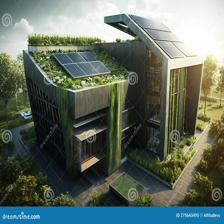

In [6]:
print(len(test_solar))
PIL.Image.open(str(test_solar[0]))

200


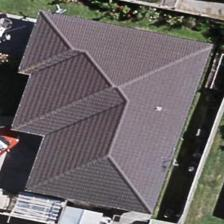

In [7]:
print(len(test_nosolar))
PIL.Image.open(str(test_nosolar[0]))

In [8]:
train_solar_dir = pathlib.Path('/content/dataset/train/solar')
train_solar = list(train_solar_dir.glob('*.jpg'))
train_nosolar_dir = pathlib.Path('/content/dataset/train/nosolar')
train_nosolar = list(train_nosolar_dir.glob('*.jpg'))
train_dir = pathlib.Path('/content/dataset/train')


523


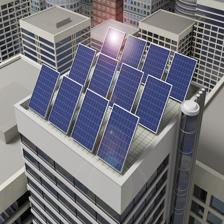

In [9]:
print(len(train_solar))
PIL.Image.open(str(train_solar[0]))

900


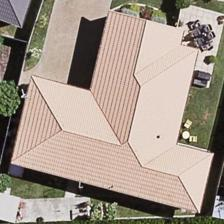

In [10]:
print(len(train_nosolar))
PIL.Image.open(str(train_nosolar[0]))

In [19]:
img_height = 224
img_width = 224
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 1800 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [20]:
classnames = train_ds.class_names
print(classnames)

['nosolar', 'solar']


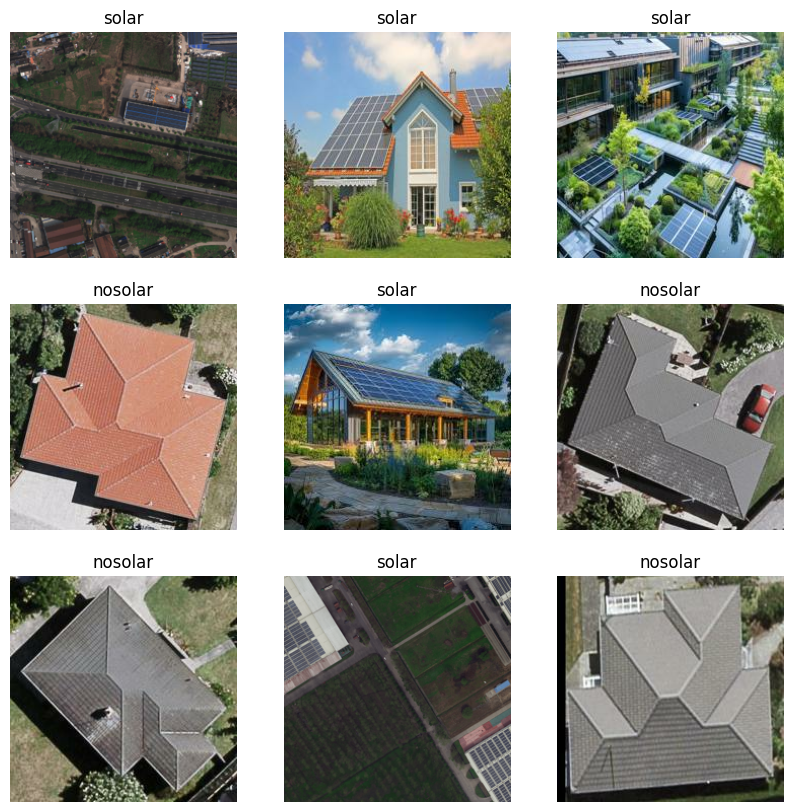

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


**Tuning to improve performance**

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Training dataset Normalization**

In [24]:
normalization_layer = layers.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


**1. Training using normal multilayer perceptron (MLP)**

In [17]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [18]:
import time
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)
end_time = time.time()
training_time = end_time - start_time
test_loss, test_acc = model.evaluate(test_ds)
model.summary()
print("Test accuracy:", test_acc)
print("Training time:", training_time)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.6501 - loss: 2964.5493 - val_accuracy: 0.9225 - val_loss: 8.3234
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.8758 - loss: 25.1893 - val_accuracy: 0.8400 - val_loss: 24.1606
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.7558 - loss: 92.6696 - val_accuracy: 0.9400 - val_loss: 14.7503
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.9154 - loss: 24.5397 - val_accuracy: 0.9425 - val_loss: 8.6224
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.9118 - loss: 18.2556 - val_accuracy: 0.9175 - val_loss: 12.5270
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.9184 - loss: 9.3106 - val_accuracy: 0.8250 - val_loss: 37.7952
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.8953 - loss: 18.0754 - val_accuracy: 0.7125 - val_loss: 88.6063
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.8431 - loss: 41.5

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,441,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,325,573 (142.39 MB)

 Trainable params: 12,441,857 (47.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,883,716 (94.92 MB)

Test accuracy: 0.9649999737739563
Training time: 154.83628630638123


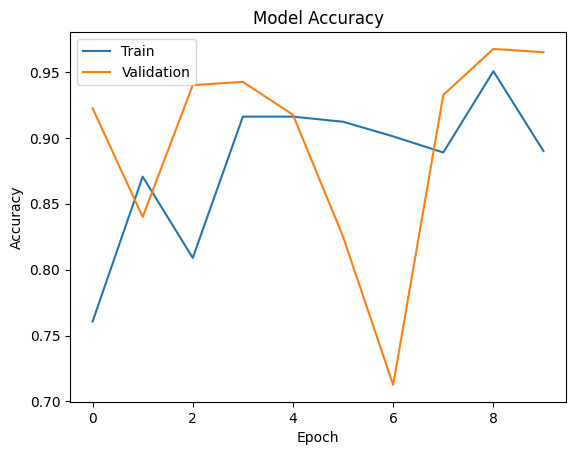

Average Training Time per Epoch: 15.483628630638123


In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)

**2. Training using CNN with only 1 hidden layers**

In [20]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [21]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)
end_time = time.time()
training_time = end_time - start_time
test_loss, test_acc = model.evaluate(test_ds)
model.summary()
print("Test accuracy:", test_acc)
print("Training time:", training_time)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 714ms/step - accuracy: 0.6457 - loss: 405.0015 - val_accuracy: 0.9850 - val_loss: 1.6487
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 704ms/step - accuracy: 0.9864 - loss: 1.3451 - val_accuracy: 0.9875 - val_loss: 0.7832
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 708ms/step - accuracy: 0.9941 - loss: 0.2644 - val_accuracy: 0.9925 - val_loss: 0.3611
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 706ms/step - accuracy: 0.9970 - loss: 0.0559 - val_accuracy: 0.9900 - val_loss: 0.3657
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 710ms/step - accuracy: 0.9889 - loss: 0.1504 - val_accuracy: 0.9925 - val_loss: 0.3262
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 703ms/step - accuracy: 0.9986 - loss: 0.0742 - val_accuracy: 0.9925 - val_loss: 0.2681
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 730ms/step - accuracy: 0.9932 - loss: 0.1182 - val_accuracy: 0.9950 - val_loss: 0.3153
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 838ms/step - accuracy: 0.9983 - loss: 0.0427 - val_ac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │         253,473 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 763,109 (2.91 MB)

 Trainable params: 254,369 (993.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 508,740 (1.94 MB)

Test accuracy: 0.9900000095367432
Training time: 497.8611876964569


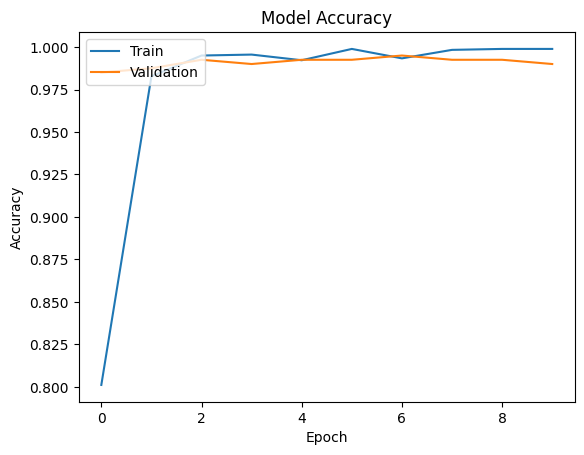

Average Training Time per Epoch: 49.78611876964569


In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)

**3. Training using CNN with multiple hidden layers**

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 822ms/step - accuracy: 0.7063 - loss: 330.7780 - val_accuracy: 0.9500 - val_loss: 4.1663
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 740ms/step - accuracy: 0.9761 - loss: 1.5970 - val_accuracy: 0.9900 - val_loss: 0.5472
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 87s 825ms/step - accuracy: 0.9921 - loss: 0.2803 - val_accuracy: 0.9900 - val_loss: 0.3680
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 774ms/step - accuracy: 0.9974 - loss: 0.0843 - val_accuracy: 0.9925 - val_loss: 1.1296
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 732ms/step - accuracy: 0.9942 - loss: 0.2725 - val_accuracy: 0.9925 - val_loss: 1.1877
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 731ms/step - accuracy: 0.9914 - loss: 0.2286 - val_accuracy: 0.9925 - val_loss: 0.7485
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 746ms/step - accuracy: 0.9995 - loss: 0.0064 - val_accuracy: 0.9900 - val_loss: 1.6119
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 768ms/step - accuracy: 0.9976 - loss: 0.0364 - val_ac

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 253472)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │         253,473 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 763,109 (2.91 MB)

 Trainable params: 254,369 (993.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 508,740 (1.94 MB)

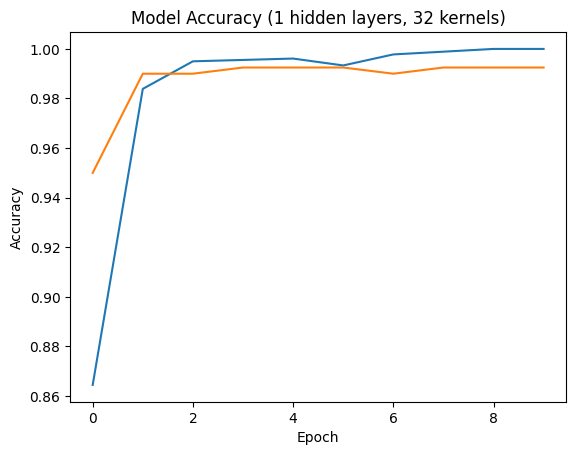

Average Training Time per Epoch: 70.20731222629547
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7489 - loss: 82.3278 - val_accuracy: 0.9925 - val_loss: 0.0148
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9653 - loss: 0.2306 - val_accuracy: 0.9900 - val_loss: 0.0489
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9781 - loss: 0.0981 - val_accuracy: 0.9850 - val_loss: 0.0468
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9960 - loss: 0.0137 - val_accuracy: 0.9925 - val_loss: 0.0483
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9991 - loss: 0.0020 - val_accuracy: 0.9900 - val_loss: 0.0322
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 1.0000 - loss: 3.3243e-04 - val_accuracy: 0.9900 - val_loss: 0.0394
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 1.0000 - loss: 2.5120e-04 - val_accuracy: 0.9875 - val_loss: 0.0374
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │         118,337 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,173 (1.80 MB)

 Trainable params: 157,057 (613.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 314,116 (1.20 MB)

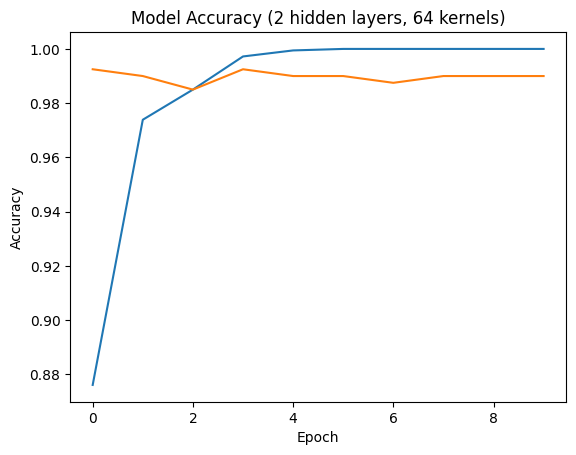

Average Training Time per Epoch: 184.91044993400573
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 459s 8s/step - accuracy: 0.7187 - loss: 21.6151 - val_accuracy: 0.9725 - val_loss: 0.0911
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 452s 8s/step - accuracy: 0.9526 - loss: 0.1594 - val_accuracy: 0.9975 - val_loss: 0.0054
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 453s 8s/step - accuracy: 0.9843 - loss: 0.0424 - val_accuracy: 0.9975 - val_loss: 0.0083
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 453s 8s/step - accuracy: 0.9943 - loss: 0.0166 - val_accuracy: 0.9925 - val_loss: 0.0125
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 454s 8s/step - accuracy: 0.9955 - loss: 0.0147 - val_accuracy: 0.9975 - val_loss: 0.0063
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 464s 8s/step - accuracy: 0.9820 - loss: 0.0701 - val_accuracy: 0.9875 - val_loss: 0.0568
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9891 - loss: 0.0449 - val_accuracy: 0.9750 - val_loss: 0.0724
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - accur

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 41, 41, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │          51,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,049,861 (4.00 MB)

 Trainable params: 349,953 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 699,908 (2.67 MB)

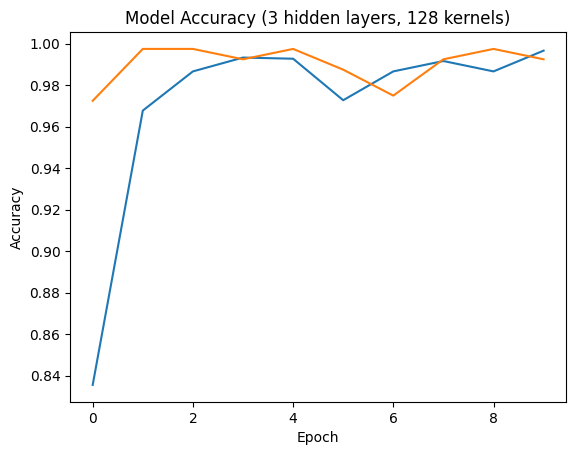

Average Training Time per Epoch: 478.034669303894


In [23]:
def create_and_train_cnn(num_hidden_layers, num_kernels):
    model = keras.Sequential()
    model.add(keras.Input(shape=(224, 224, 3)))
    for i in range(num_hidden_layers):
        model.add(layers.Conv2D(num_kernels, kernel_size=(3, 3), activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    start_time = time.time()
    history = model.fit(train_ds, epochs=10, validation_data=test_ds)
    end_time = time.time()
    training_time = end_time - start_time
    model.summary()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy ({num_hidden_layers} hidden layers, {num_kernels} kernels)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    epochs = len(history.history['accuracy'])
    time_per_epoch = training_time / epochs
    print("Average Training Time per Epoch:", time_per_epoch)

configurations = [
    (1, 32),  # 1 hidden layer, 32 kernels
    (2, 64),  # 2 hidden layers, 64 kernels
    (3, 128)  # 3 hidden layers, 128 kernels
]

for num_hidden_layers, num_kernels in configurations:
    create_and_train_cnn(num_hidden_layers, num_kernels)

**4. Training using ResNet50**


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 378s 7s/step - accuracy: 0.8242 - loss: 0.3456 - val_accuracy: 0.9950 - val_loss: 0.0367
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 377s 7s/step - accuracy: 0.9953 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 365s 6s/step - accuracy: 0.9975 - loss: 0.0239 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 365s 6s/step - accuracy: 0.9964 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 0.0103
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 380s 6s/step - accuracy: 0.9997 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 366s 6s/step - accuracy: 0.9970 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 365s 6s/step - accuracy: 0.9999 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 366s 6s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - v

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,593,861 (90.00 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,100 (16.02 KB)

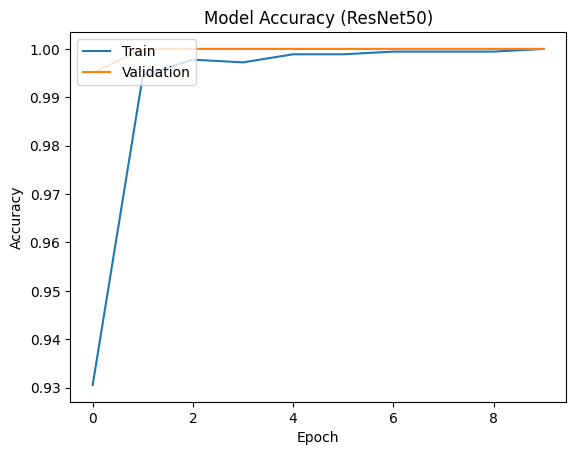

Average Training Time per Epoch: 368.6890820980072


In [26]:
import time
base_model = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

end_time = time.time()
training_time = end_time - start_time
model.summary()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (ResNet50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)